# Experiment2_LightGBM+feature engineering

This notebook will use LightGBM to predict whether a college basketball player will be drafted into the NBA based solely on season statistics. This model helps NBA teams decide who to watch in person, plan for the draft, and see if their own ratings match the predictions. 

The steps are:
1. Setting up new Git Repository
2. Load and Explore data
3. Data preparation
4. Train Classifiers
5. Prediction
6. Feature importance
7. Push changes

In [1]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Qt5Agg') 
%matplotlib inline
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier

## 1. Setting up Git Repository

**[1.1]** Go to the folder I created previously `adv_mla`

In [2]:
cd /Users/frodo/Downloads/36120/Project/adv_mla/ass1/

/Users/frodo/Downloads/36120/Project/adv_mla/ass1


**[1.2]** Copy the cookiecutter data science template

In [ ]:
cookiecutter -c v1 https://github.com/drivendata/cookiecutter-data-science

**[1.3]** Initialise the repo

In [ ]:
git init

**[1.4]** In your local repo, link it with Github (replace the url with your username)

In [ ]:
git remote add origin git@github.com:frodorocky/ass1.git

**[1.5]** Create a new git branch called `first_experiment`

In [ ]:
git checkout -b first_experiment

## 2. Load and explore data

We will do data cleaning and data exploration simultaneously because data exploration often goes hand in hand with data cleaning processes in our experiment

**[2.1]** Load data and set the index of a DataFrame to the values of the column 'player_id'.

In [3]:
from src.data.DataProcessor import DataProcessor

In [4]:
train = DataProcessor.load_and_preprocess('data/raw/train.csv')

Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.


**[2.2]** Display the first 5 rows of df

In [5]:
train.head()

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,drafted
player_id,,,,,,,,,,,,,,,,,,,,,
7be2aead-da4e-4d13-a74b-4c1e692e2368,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,...,-2.781990,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,0.0
61de55d9-1582-4ea4-b593-44f6aa6524a6,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,...,-0.052263,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,0.0
efdc4cfc-9dd0-4bf8-acef-7273e4d5b655,South Florida,BE,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,...,1.548230,-0.883163,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852,0.0
14f05660-bb3c-4868-b3dd-09bcdb64279d,Pepperdine,WCC,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,...,-0.342775,-0.393459,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333,0.0
a58db52f-fbba-4e7b-83d0-371efcfed039,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,...,-1.684860,-0.668318,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758,0.0


**[2.3]** Display the shape of train data

In [6]:
train.shape

(56091, 63)

There are 56091 observations with 63 features

**[2.4]** Display the information of each columns

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56091 entries, 7be2aead-da4e-4d13-a74b-4c1e692e2368 to 65571c18-b2b4-4ba6-84db-7357a76e6f59
Data columns (total 63 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 56091 non-null  object 
 1   conf                 56091 non-null  object 
 2   GP                   56091 non-null  int64  
 3   Min_per              56091 non-null  float64
 4   Ortg                 56091 non-null  float64
 5   usg                  56091 non-null  float64
 6   eFG                  56091 non-null  float64
 7   TS_per               56091 non-null  float64
 8   ORB_per              56091 non-null  float64
 9   DRB_per              56091 non-null  float64
 10  AST_per              56091 non-null  float64
 11  TO_per               56091 non-null  float64
 12  FTM                  56091 non-null  int64  
 13  FTA                  56091 non-null  int64  
 14  FT_per               5609

**[2.5]** compute missing ratio of each column

In [8]:
def compute_missing_ratio(df):
    missing_ratio = df.isnull().sum() / len(df) * 100
    missing_ratio_sorted = missing_ratio.sort_values(ascending=False)
    return missing_ratio_sorted

In [9]:
print(compute_missing_ratio(train))

pick           97.529015
Rec_Rank       69.627926
dunks_ratio    54.898290
mid_ratio      17.271933
rim_ratio      16.872582
                 ...    
ftr             0.000000
porpag          0.000000
adjoe           0.000000
pfr             0.000000
drafted         0.000000
Length: 63, dtype: float64


**[2.6]** drop the columns with high proportion of missing value

In [10]:
train_cleaned = train.drop(['pick','Rec_Rank','dunks_ratio'], axis=1)

**[2.7]** Description of cleaned data

In [11]:
train_cleaned.describe()

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,drafted
count,56091.000000,56091.000000,56091.000000,56091.000000,56091.000000,56091.000000,56091.000000,56091.000000,56091.000000,56091.000000,...,56047.000000,56047.000000,56053.000000,56053.000000,56053.000000,56053.000000,56053.000000,56053.000000,56053.000000,56091.000000
mean,23.411973,37.325229,91.858295,18.149265,44.575513,47.676882,5.575376,12.673716,10.848740,20.337819,...,-2.083375,-0.442297,0.770611,1.892593,2.663204,1.073038,0.529475,0.282825,5.775381,0.009556
std,10.090542,28.061897,30.538819,6.204489,18.213813,17.414133,9.480239,10.878099,9.356001,12.226129,...,6.190166,3.279438,0.738899,1.479148,2.099913,1.171148,0.469152,0.417754,4.953723,0.097287
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-141.539000,-100.984000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,9.500000,84.100000,14.500000,40.100000,43.930000,1.800000,8.400000,4.600000,14.800000,...,-4.426515,-1.728030,0.225800,0.700000,1.000000,0.222200,0.160000,0.000000,1.571400,0.000000
50%,28.000000,35.900000,97.100000,18.100000,47.700000,50.850000,4.300000,11.900000,9.100000,19.100000,...,-1.580380,-0.313051,0.545500,1.633300,2.259300,0.677400,0.424200,0.133300,4.482800,0.000000
75%,31.000000,62.200000,106.900000,21.800000,53.200000,56.060000,8.100000,16.000000,15.100000,24.500000,...,0.992335,1.066415,1.111100,2.758600,3.833300,1.533300,0.793100,0.366700,9.069000,0.000000
max,41.000000,98.000000,834.000000,50.000000,150.000000,150.000000,1576.600000,1385.000000,100.000000,100.000000,...,225.485000,78.985500,5.933300,11.545500,14.533300,10.000000,4.000000,5.258100,30.090900,1.000000


We can see there are some negative values in our dataset, but negative values are usually not present in this case, we may handle this problem in the data preprocess step

**[2.8]** Distribution of Y

In [12]:
# Extract the target variable into a variable called y
df, y = DataProcessor.separate_target_variable(train_cleaned, 'drafted')

In [13]:
y.value_counts()

0.0    55555
1.0      536
Name: drafted, dtype: int64

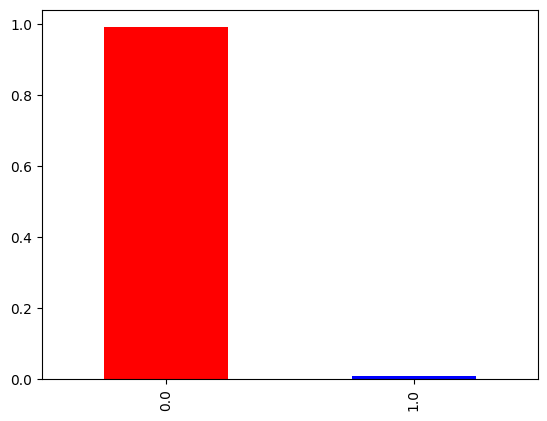

In [14]:
# Calculate positive and negative sample ratios
sizes = y.value_counts(normalize=True).plot(kind="bar", color=["red", "blue"])

## 3. Data Preparation

**[3.1]** add derived variables

In [22]:
# One-hot encoding for 'team' and 'conf' columns
#train_df_encoded = pd.get_dummies(train_cleaned, columns=['team', 'conf'], drop_first=True)

# Deriving average points per game from 'GP' and 'pts'
df['avg_points_per_game'] = df['pts'] / df['GP']

# Deriving Ortg difference from mean
ortg_mean = df['Ortg'].mean()
df['Ortg_diff_from_mean'] = df['Ortg'] - ortg_mean

# Interaction feature between 'usg' and 'Ortg'
df['usg_Ortg_interaction'] = df['usg'] * df['Ortg']

# Polynomial features for 'Ortg'
df['Ortg_square'] = df['Ortg'] ** 2

# Rolling averages for 'pts' with a window of 3
df['pts_rolling_avg'] = df['pts'].rolling(window=3).mean().fillna(0)

# Display the first few rows of the DataFrame after additional feature engineering
df[['usg', 'Ortg', 'usg_Ortg_interaction', 'Ortg_square', 'pts', 'pts_rolling_avg']].head()

# Display the first few rows of the DataFrame after feature engineering
df.head()

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,treb,ast,stl,blk,pts,avg_points_per_game,Ortg_diff_from_mean,usg_Ortg_interaction,Ortg_square,pts_rolling_avg
player_id,,,,,,,,,,,,,,,,,,,,,
7be2aead-da4e-4d13-a74b-4c1e692e2368,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,...,0.8077,1.1923,0.3462,0.0385,3.8846,0.149408,5.441705,1615.18,9467.29,0.000000
61de55d9-1582-4ea4-b593-44f6aa6524a6,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,...,1.9412,1.8235,0.4118,0.2353,5.9412,0.174741,16.441705,1613.67,11728.89,0.000000
efdc4cfc-9dd0-4bf8-acef-7273e4d5b655,South Florida,BE,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,...,2.9630,1.9630,0.4815,0.0000,12.1852,0.451304,4.341705,2097.16,9254.44,7.337000
14f05660-bb3c-4868-b3dd-09bcdb64279d,Pepperdine,WCC,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,...,2.1333,1.1000,0.5667,0.1333,4.9333,0.164443,5.841705,1563.20,9545.29,7.686567
a58db52f-fbba-4e7b-83d0-371efcfed039,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,...,4.7273,0.8485,0.4545,0.3333,7.5758,0.229570,4.641705,2123.00,9312.25,8.231433


**[3.2]** feature selection

In [23]:
from src.features.feature_selector import FeatureSelector

# Initialize FeatureSelector
fs = FeatureSelector(data=df, labels=y)

In [24]:
fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.95, 
                                    'task': 'classification', 'eval_metric': 'auc',
                                     'cumulative_importance': 0.99, 'importance_type': 'gain'})

0 features with greater than 0.60 missing values.

1 features with a single unique value.



The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


12 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.988534	valid_0's binary_logloss: 0.0221658
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.982997	valid_0's binary_logloss: 0.0268304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.983238	valid_0's binary_logloss: 0.0267087
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.982991	valid_0's binary_logloss: 0.0262502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.986231	valid_0's binary_logloss: 0.0275288
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


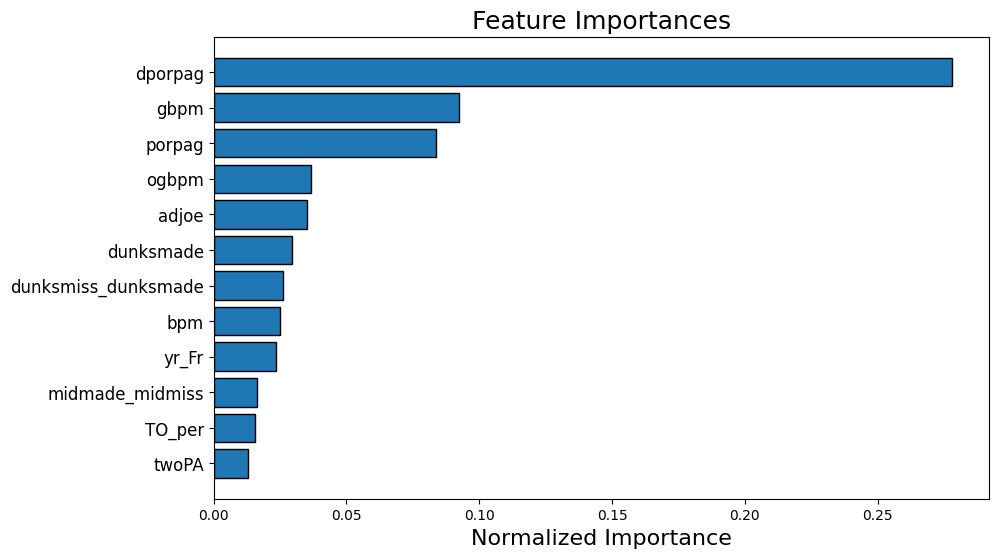

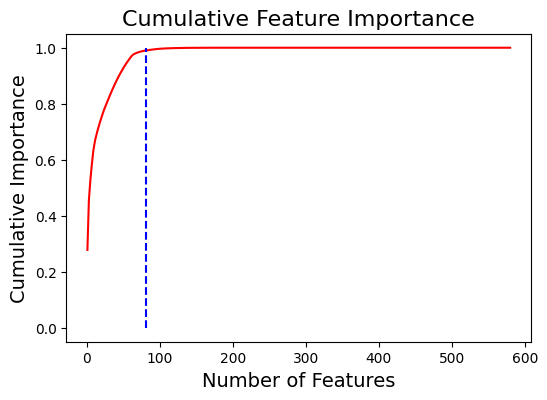

81 features required for 0.99 of cumulative importance


In [25]:
# Review the identified features to be removed
fs.plot_feature_importances(threshold=0.99, plot_n=12)  # Adjust parameters as needed

In [26]:
# Remove the identified features

In [27]:
train_removed = fs.remove(methods = 'all', keep_one_hot = False)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 536 features including one-hot features.


In [28]:
train_removed.columns

Index(['team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per',
       'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FT_per', 'twoPM',
       'twoP_per', 'TPM', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'yr', 'ht',
       'num', 'porpag', 'pfr', 'year', 'ast_tov', 'midmade', 'rim_ratio',
       'mid_ratio', 'dunksmade', 'drtg', 'adrtg', 'dporpag', 'bpm', 'obpm',
       'dbpm', 'gbpm', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'ast', 'stl', 'blk',
       'pts', 'avg_points_per_game', 'usg_Ortg_interaction',
       'pts_rolling_avg'],
      dtype='object')

**[3.3]** identify numeric features and categorical features

In [29]:
num_cols, cat_cols = DataProcessor.get_feature_types(train_removed)

**[3.4]** convert the value of categorical features to string format

In [30]:
def convert_to_string(X):
    return X.astype(str)

stringify_transformer = FunctionTransformer(func=convert_to_string, validate=False)

**[3.5]** filling the missing value with "missing" 

In [31]:
categorical_transformer = Pipeline(steps=[
    ('stringify', stringify_transformer),
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    #('encoder', OneHotEncoder(handle_unknown='ignore'))
])

**[3.6]** encoding categorical features

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='passthrough')

## 4. Train model

**[4.1]** defining the pipeline of preprocessor and trainer

In [33]:
# Create Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(class_weight='balanced', random_state=42))
])

**[4.2]** defining the hyper-parameters

In [34]:
# Define parameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__n_estimators': [20, 50, 100, 200, 500,1000],
    'classifier__num_leaves': [31, 62, 93],
    'classifier__reg_alpha': [0.0, 0.1, 0.5, 1.0],  # Add L1 regularization
    'classifier__reg_lambda': [0.0, 0.1, 0.5, 1.0], # Add L2 regularization
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

**[4.3]** Fit the GridSearchCV 

In [35]:
grid_search.fit(train_removed, y)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('stringify',
                                                                                          FunctionTransformer(func=<function convert_to_string at 0x7fa129399550>)),
                                                                                         ('imputer',
                                                                                          SimpleImputer(fill_value='Missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value...
                                                                         Index(['team', 'conf', 'yr', 'ht', 'num'], dtype='object'))])),
                                       ('classifier',
                                        LGBMClassifier(class_weight='balanced',
                                                       random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 1],
                         'classifier__n_estimators': [20, 50, 100, 200, 500,
                                                      1000],
                         'classifier__num_leaves': [31, 62, 93],
                         'classifier__reg_alpha': [0.0, 0.1, 0.5, 1.0],
                         'classifier__reg_lambda': [0.0, 0.1, 0.5, 1.0]},
             scoring='roc_auc', verbose=1)

**[4.4]**  Get the best model

In [36]:
best_model = grid_search.best_estimator_

**[4.5]**  Print the best parameters

In [37]:
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'classifier__reg_alpha': 0.0, 'classifier__reg_lambda': 1.0}


In [38]:
print("Best AUC:", grid_search.best_score_)

Best AUC: 0.9860430644804892


**[4.6]**  save the best model

In [39]:
import joblib

joblib.dump(best_model, 'models/best_model_week2.joblib')

['models/best_model_week2.joblib']

## 5. Prediction on test data

Finally we applied the trained model on test data and upload our result to obtain score

**[5.1]** Load dataset

In [40]:
test = DataProcessor.load_and_preprocess('data/raw/test.csv')

In [41]:
test.columns

Index(['team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per',
       'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per',
       'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per',
       'stl_per', 'ftr', 'yr', 'ht', 'num', 'porpag', 'adjoe', 'pfr', 'year',
       'type', 'Rec_Rank', 'ast_tov', 'rimmade', 'rimmade_rimmiss', 'midmade',
       'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade',
       'dunksmiss_dunksmade', 'dunks_ratio', 'pick', 'drtg', 'adrtg',
       'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm',
       'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts'],
      dtype='object')

**[5.2]** keep the identical features as train dataset

In [42]:
# Deriving average points per game from 'GP' and 'pts'
test['avg_points_per_game'] = test['pts'] / test['GP']

# Deriving Ortg difference from mean
ortg_mean = test['Ortg'].mean()
test['Ortg_diff_from_mean'] = test['Ortg'] - ortg_mean

# Interaction feature between 'usg' and 'Ortg'
test['usg_Ortg_interaction'] = test['usg'] * test['Ortg']

# Polynomial features for 'Ortg'
test['Ortg_square'] = test['Ortg'] ** 2

# Rolling averages for 'pts' with a window of 3
test['pts_rolling_avg'] = test['pts'].rolling(window=3).mean().fillna(0)

# Display the first few rows of the DataFrame after additional feature engineering
test[['usg', 'Ortg', 'usg_Ortg_interaction', 'Ortg_square', 'pts', 'pts_rolling_avg']].head()

,usg,Ortg,usg_Ortg_interaction,Ortg_square,pts,pts_rolling_avg
player_id,,,,,,
cf302b4d-84f7-4124-a25d-a75eed31978b,4.7,115.1,540.97,13248.01,1.0000,0.000000
f91837cd-4f49-4b70-963d-aeb82c6ce3da,18.6,61.1,1136.46,3733.21,2.3636,0.000000
53ec2a29-1e7d-4c6d-86d7-d60d02af8916,23.8,91.9,2187.22,8445.61,8.8889,4.084167
32402798-471c-4a54-8cb4-29cd95199014,10.4,111.0,1154.40,12321.00,0.7143,3.988933
73b960f9-27b8-4431-9d23-a760e9bbc360,21.5,103.1,2216.65,10629.61,14.3043,7.969167


In [43]:
# Get the feature names from the train_removed DataFrame
selected_features = train_removed.columns

# Select only the matching features from the test DataFrame
test_selected = test[selected_features]

**[5.3]** Load model

In [44]:
import joblib

# Load the model from the file 
load_model = joblib.load('models/best_model_week2.joblib') 

**[5.4]**  Use the best estimator to predict on the test data


In [45]:
y_pred = load_model.predict(test)
y_pred_proba = load_model.predict_proba(test)[:, 1]

In [46]:
test['drafted'] = y_pred_proba 

In [47]:
test['drafted']

player_id
cf302b4d-84f7-4124-a25d-a75eed31978b    0.000060
f91837cd-4f49-4b70-963d-aeb82c6ce3da    0.000074
53ec2a29-1e7d-4c6d-86d7-d60d02af8916    0.001215
32402798-471c-4a54-8cb4-29cd95199014    0.000079
73b960f9-27b8-4431-9d23-a760e9bbc360    0.000463
                                          ...   
a25ee55f-02a3-4f8e-8194-a5f427e14e7c    0.000245
d0d9f45e-7b01-44b3-8d40-514ec338611d    0.000119
f8df22c4-1602-4fab-896d-8820951aae2f    0.000081
b791c69a-f769-4163-afda-051a6fd20a9d    0.000081
18b51f5d-4746-4121-88fd-c8d0a1399130    0.000120
Name: drafted, Length: 4970, dtype: float64

**[5.5]** save the result

In [ ]:
test['drafted'].to_csv('submission_week2.csv')

## 6. Feature importance

**[6.1]** compute feature importance and plot feature importance

In [48]:
from src.visualization.FeatureImportant import FeatureImportance

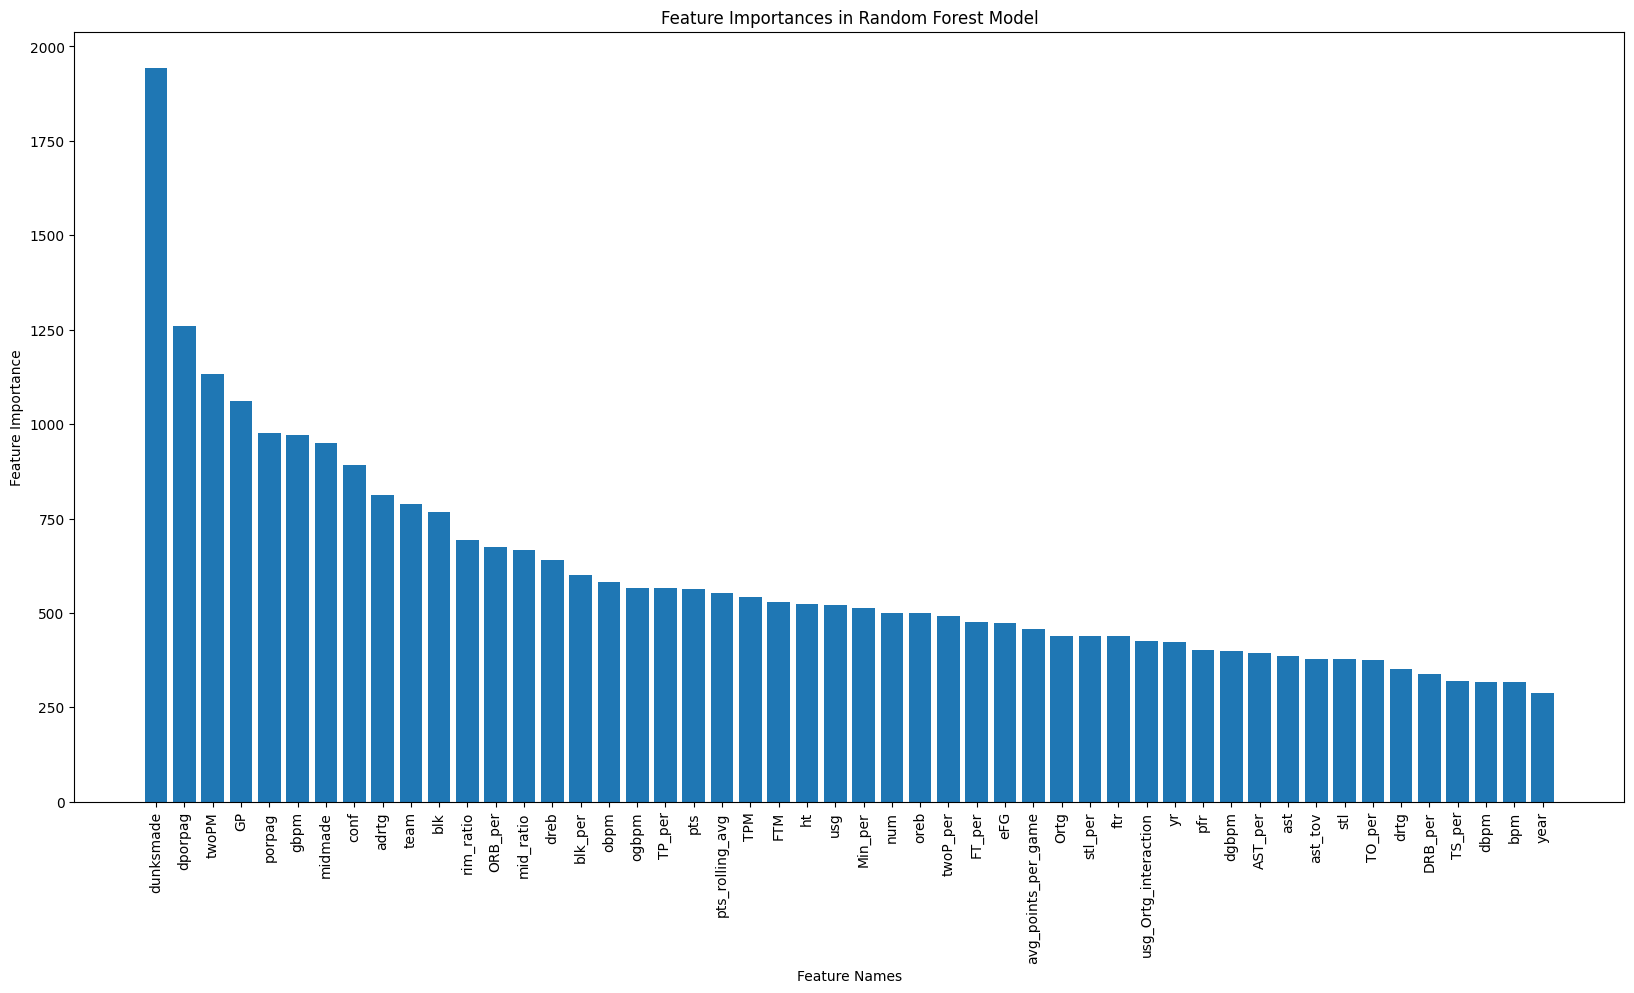

In [49]:
FeatureImportance.compute_and_plot(load_model, train_removed.columns)

## 7. Push changes

**[7.1]** Add the changes to git staging area

In [ ]:
git add .

**[7.2]** Create the snapshot of the repository and add a description

In [ ]:
git checkout -b second_experiment

In [ ]:
git commit -m "second experiment"

**[7.3]** Push snapshot to Github

In [ ]:
git push --set-upstream origin second_experiment

## Reference

So, A. (2023). 36114_AdvDSI_Lab2_Exercise3_Solutions. https://drive.google.com/file/d/17UpMxkj4slAQ2BDyAeNEYzUfTA9Ww3x6/view